### Overview

This is a quick guide for those interested in using the large and varied economic timeseries offered within Eikon - using the Data API. In ths article I will show what economic data is available in Eikon, how to navigate it and download it and finally put it into use with a simple machine learning example using an XGBoost model.

**Sections**

[Eikon Search Workflow](#ESW)

[Real-time Economic Indicators](#RTE)

[Non Real-time Economic Indicators](#NRTE)

[Putting it all together - a basic machine learning sample](#PIAT)

[Adding Target Variables or Labels](#LABELS)

[Define and fit XGBoost Model](#XGB)

[Conclusion](#CONCL)

**Pre-requisites:**

**Thomson Reuters Eikon / Refinitiv Workspace** with access to [Eikon Data APIs](https://refini.tv/3bvPev5) (Free Trial Available)

Python 2.x/3.x

Required Python Packages: [eikon](https://pypi.org/project/eikon/), [pandas](https://pypi.org/project/pandas/), [numpy](https://pypi.org/project/numpy/), [xgboost](https://pypi.org/project/xgboost/), [sci-kit Learn](https://pypi.org/project/scikit-learn/)

First of all Eikon carries around 1800 realtime economic indicators from around the globe. The are economic indicators where we track the releases in realtime over our realtime network and provide additional value-added information such as Reuters Polls as well as other useful information such as significance of the economic indicator.  Addtionally, Eikon carries over 400,000 non-realtime economic indicators globally. In the near future, the number of non-realtime indicators will more than double to 1 million timeseries. This is a great deal of economic timeseries for you to potentially work with to generate insight and models. This guide is to help developers and quant analysts to navigate this datascape.

A popular previous way to navigate economic data was to use the <ECONOMY> speed guide in Eikon. However, this has been removed in favour of an Eikon Search based workflow. Further, support for the realtime economic chain RICS such as <0#ECONALLUS>, <0#ECONALLJP> etc have been removed - so whilst these chain RICS still work - they are not being maintained. 

<a id='ESW'></a>
### Eikon Search Workflow

I mentioned above that the Eikon Search Workflow is now the main way to discover what economic indicator data is available. So lets see how this works. Please try typing *'UK Economic Indicators'* into the Eikon search bar and hitting 'more search results' at the bottom. Please see the result below. 

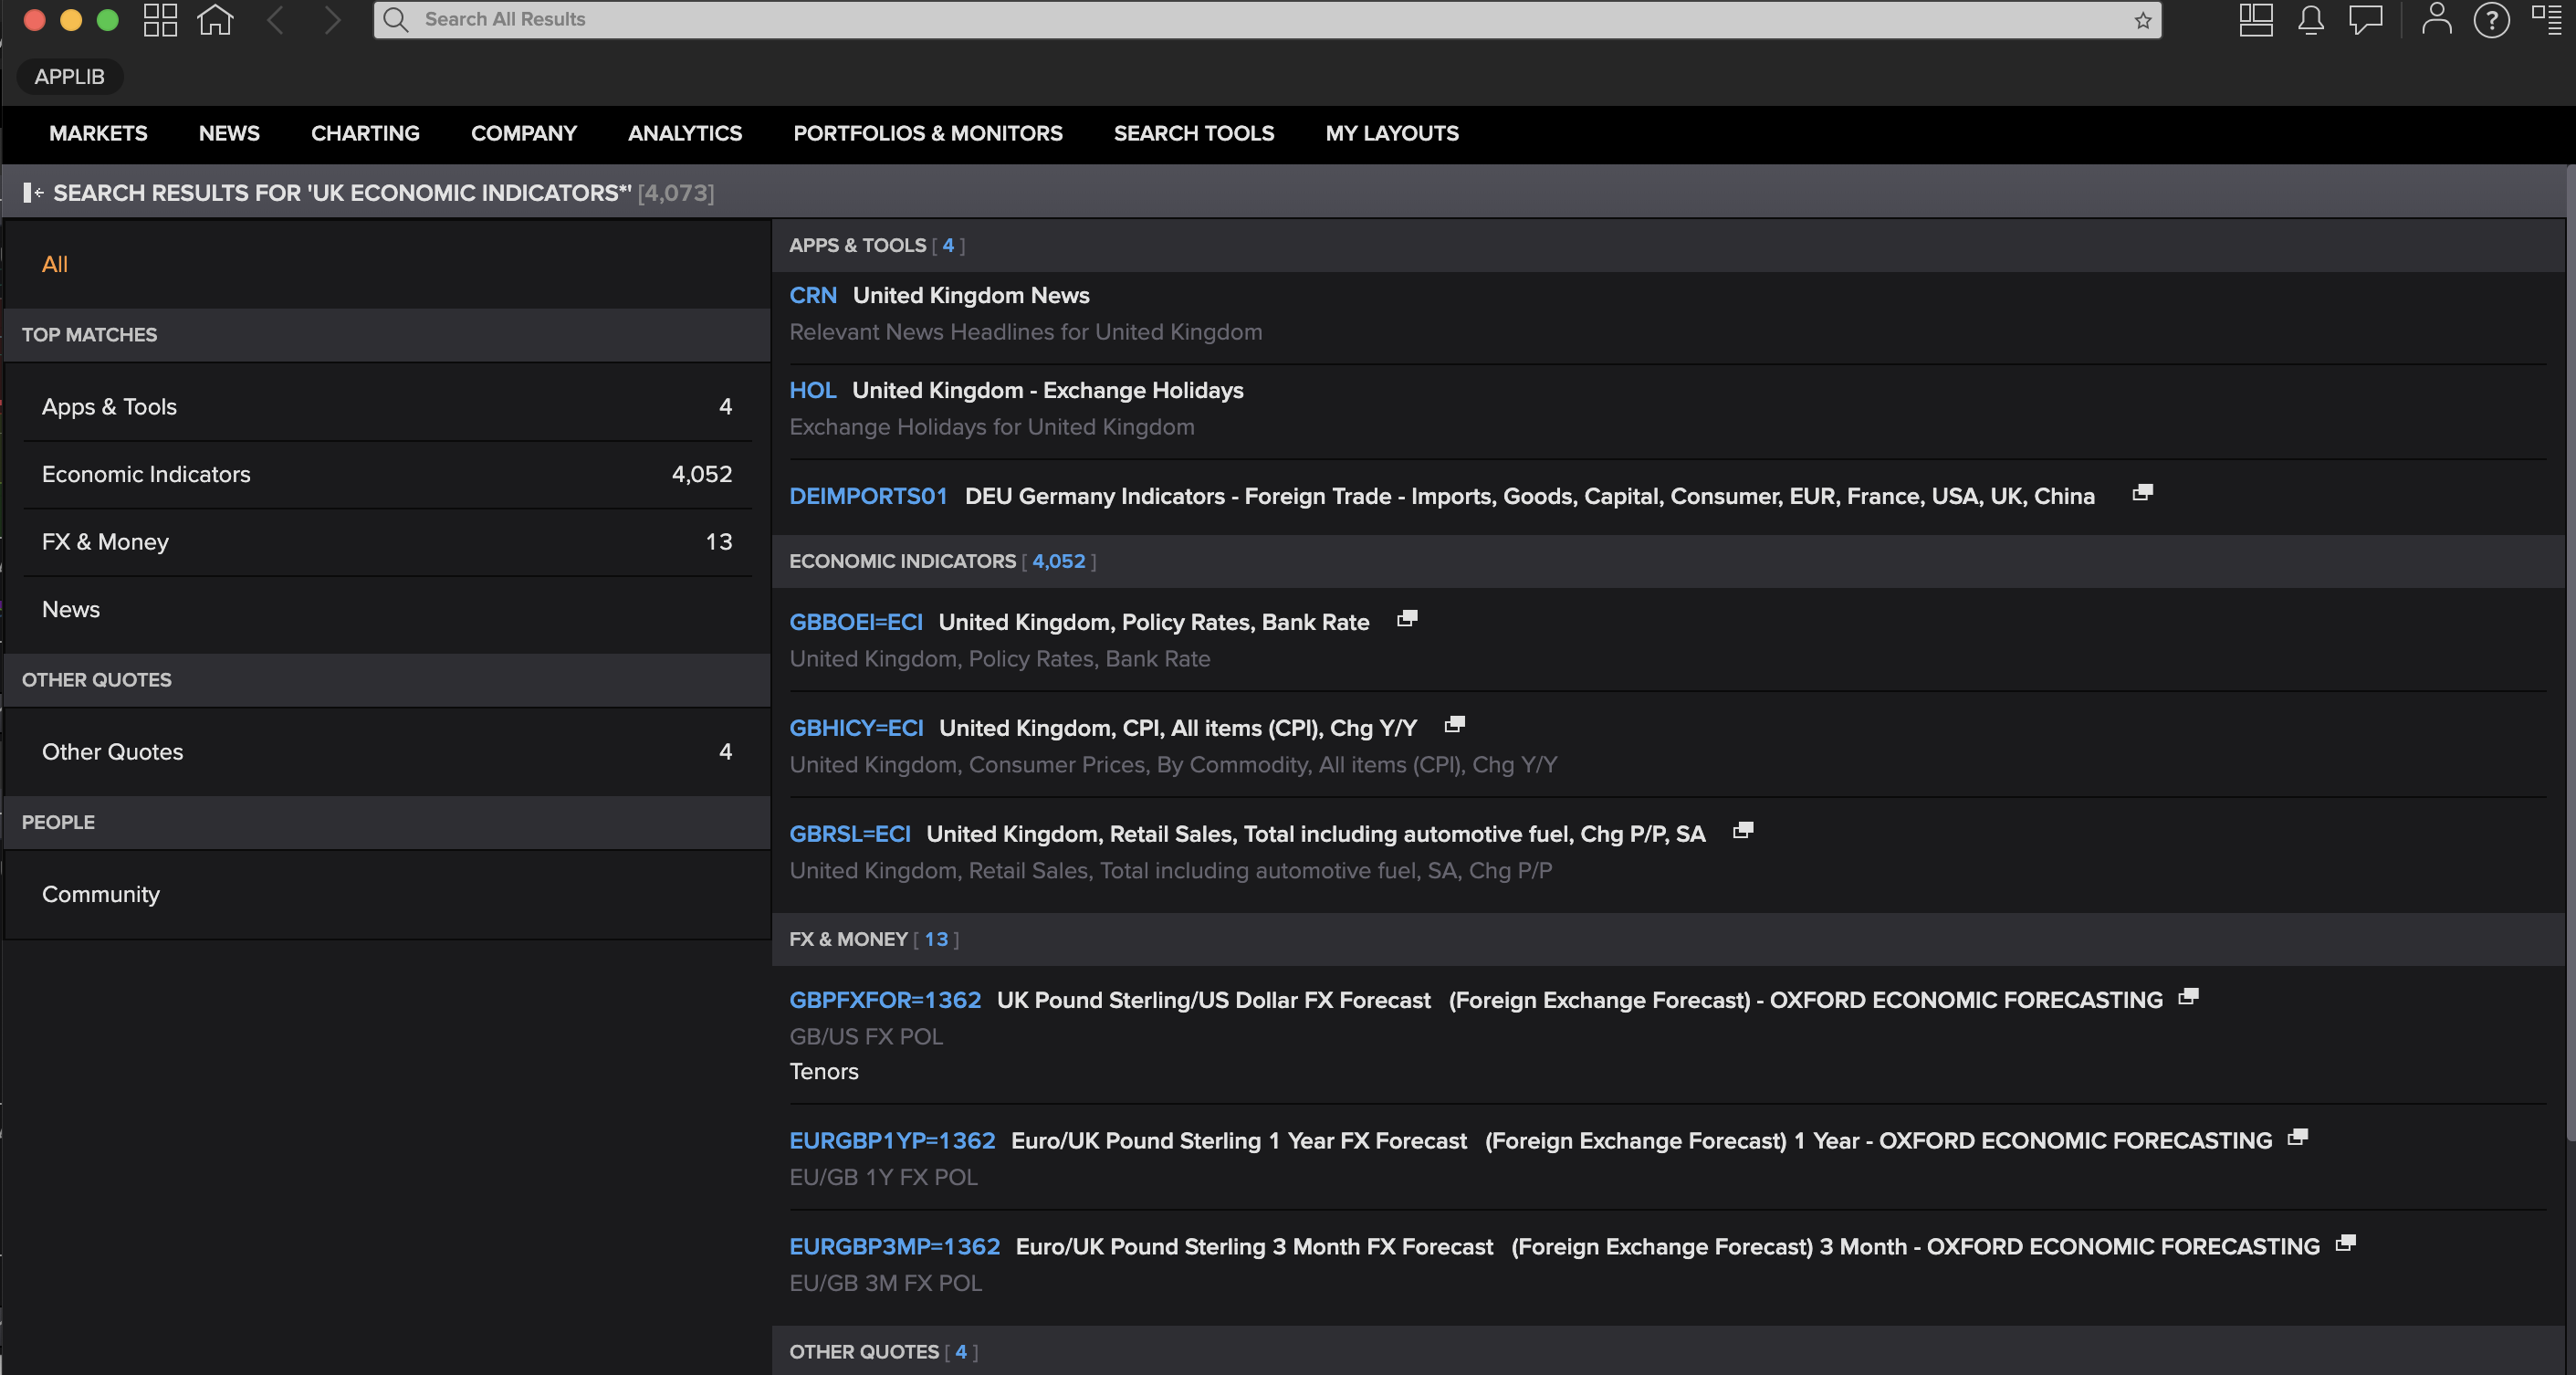

From this if we look at the Economic Indicators section we can see that over 4000 items are returned. So lets click on that to discover more. 

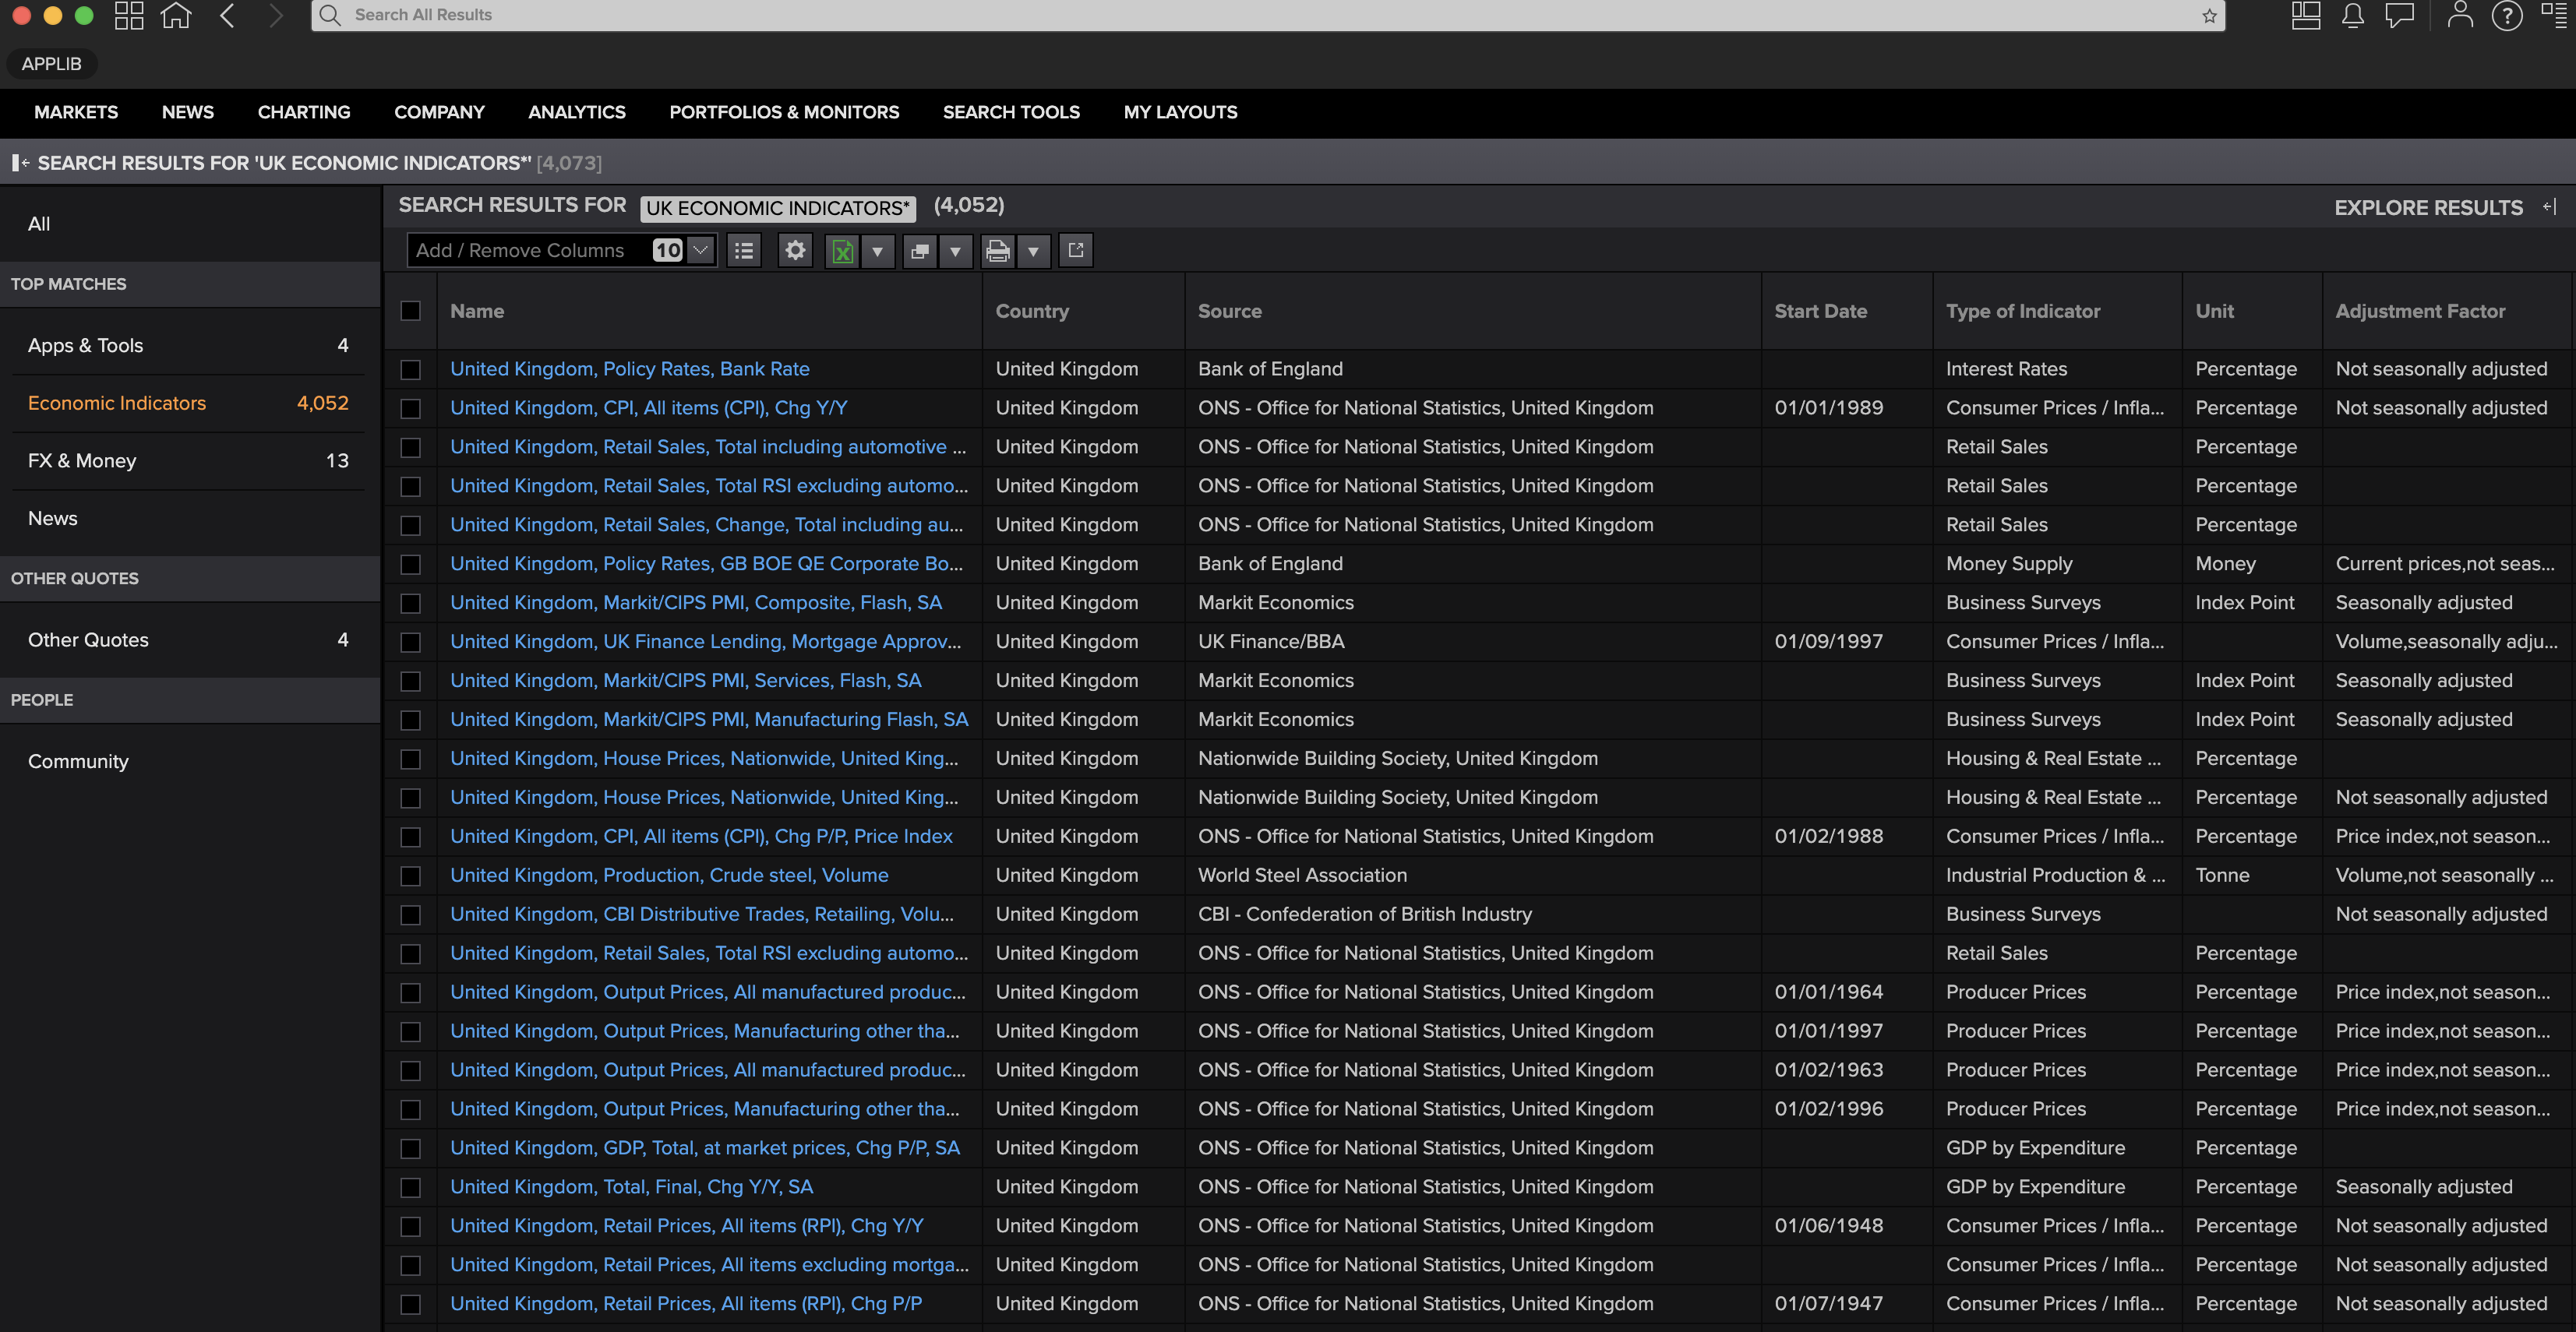

We are now at the main filter page so we can filter from the 10 columns that are there. The most useful will probably be source, periodicity and perhaps most importantly Indicator Type. Please see the types listed below:

Multiple Economic Indicator Data Sources

| Types of Economic Indicator | Types of Economic Indicator | Types of Economic Indicator|
|:----------------------------|:-------------------------------------------|:------------------------------|
Business Surveys            |  Industrial Production & Utilisation      |   Population                 |
Imports & Exports           |  Energy & Environment                     |   Consumer Prices / Inflation|
GDP/GVA by Industry         |  Workforce & Unemployment                 |   Domestic Finance           |
Automobiles & Transport     |  Macro Forecasts                          |   Balance of Payments        |
GDP by Expenditure          |  Sales, Orders & Inventories              |   Stocks, Bonds, Futures     |
Banking                     |  Agriculture                              |   Consumer Surveys           |
Money Supply                |  Exchange Rates and Operations            |   Other Commodities          |
Housing & Real Estate Prices|  Housing & Construction                   |   Consumption                |
International Reserves      |  Producer Prices                          |   Employment & Hours         |
External Debt               |  Investment / Capital Formation           |   Government Accounts        |
Retail Sales                |  Financial & Flow of Funds Accounts       |   Other Industries           |
Interest Rates              |  Foreign Transactions                     |   Incomes & Savings          | 
Import & Export Price Indices| Wages & Earnings                         |   Government Debt & Borrowing|
GDP Deflators               |  Other National Accounts                  |   International Investment Position|
Cyclical & Activity Indices |  Commodity Fundamentals                   |   Productivity & Labour Costs|
Consumer Finance            |  Central Banking                          |   Corporate Accounts & Actions|
Sector Accounts             |  Other Prices                             |   Personal Expenditures|
Other Surveys               |  Commodity Prices & Indices               |   Industry Balance Sheets|
Regional Accounts           |  Credit Risk & Ratings|

Once we narrow down what we are targetting we can then go to the page view and then download a list of appropriate RICS to excel. From there we can copy and paste these as an instrument list for use in our API Call.

In [1]:
import eikon as ek
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
ek.set_app_key('5e69a8b3903a4c50ab44d4cc565db992d85b81ef')

<a id='RTE'></a>
### Real-time Economic Indicators

As mentioned earlier Eikon carries about 1800 real-time economic indicators. Lets see what we are taking about by looking at the economic monitor (type EM into Eikon Search) for say the US (filter on US). Notice here we can see the recent and upcoming economic indicators for the next week or so with a date as well as time, importance of release, polls to see what expectations are, as well as details about these polls such as min, max, median.

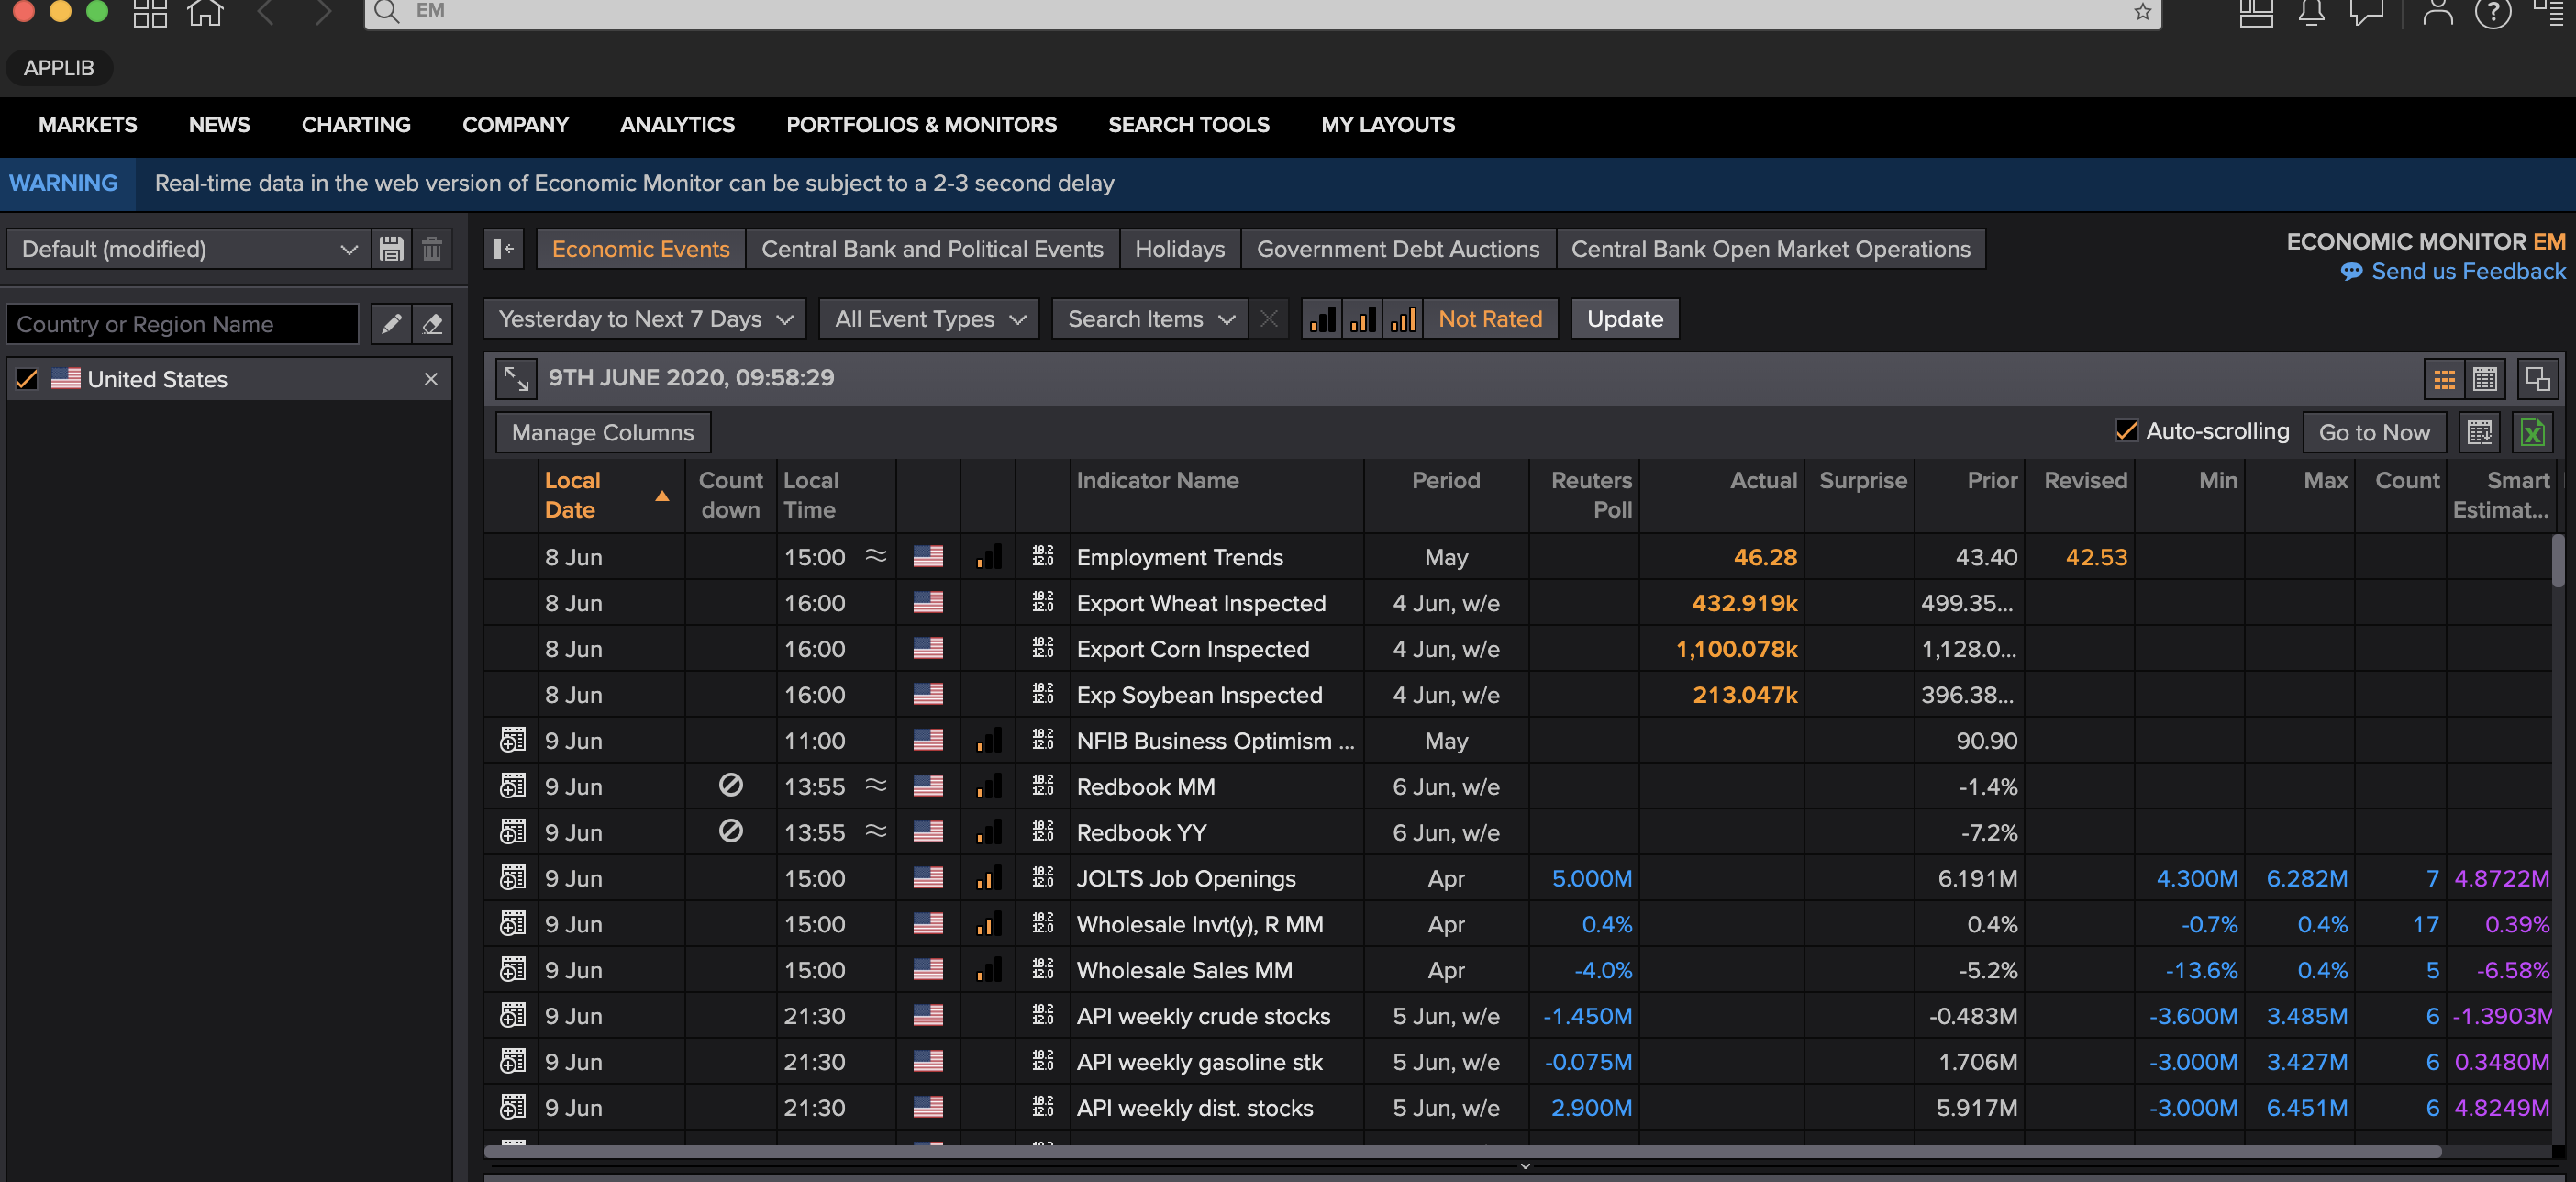


For realtime indicators lets make a simple call to the Data API get_data service. Here we are using the no longer maintained economic chain RIC '0#ECONALLUS'. These still work for backward compatibility but are no longer maintained from a content perspective. This can give us a programatic version of the Economic Monitor App above. We are using the realtime quote model for economic indicators here and you can see this by typing a realtime RIC - say 'USADP=ECI' (US ADP payrolls) and hitting quote. If you hover the mouse over a particular number you will get the field name. 

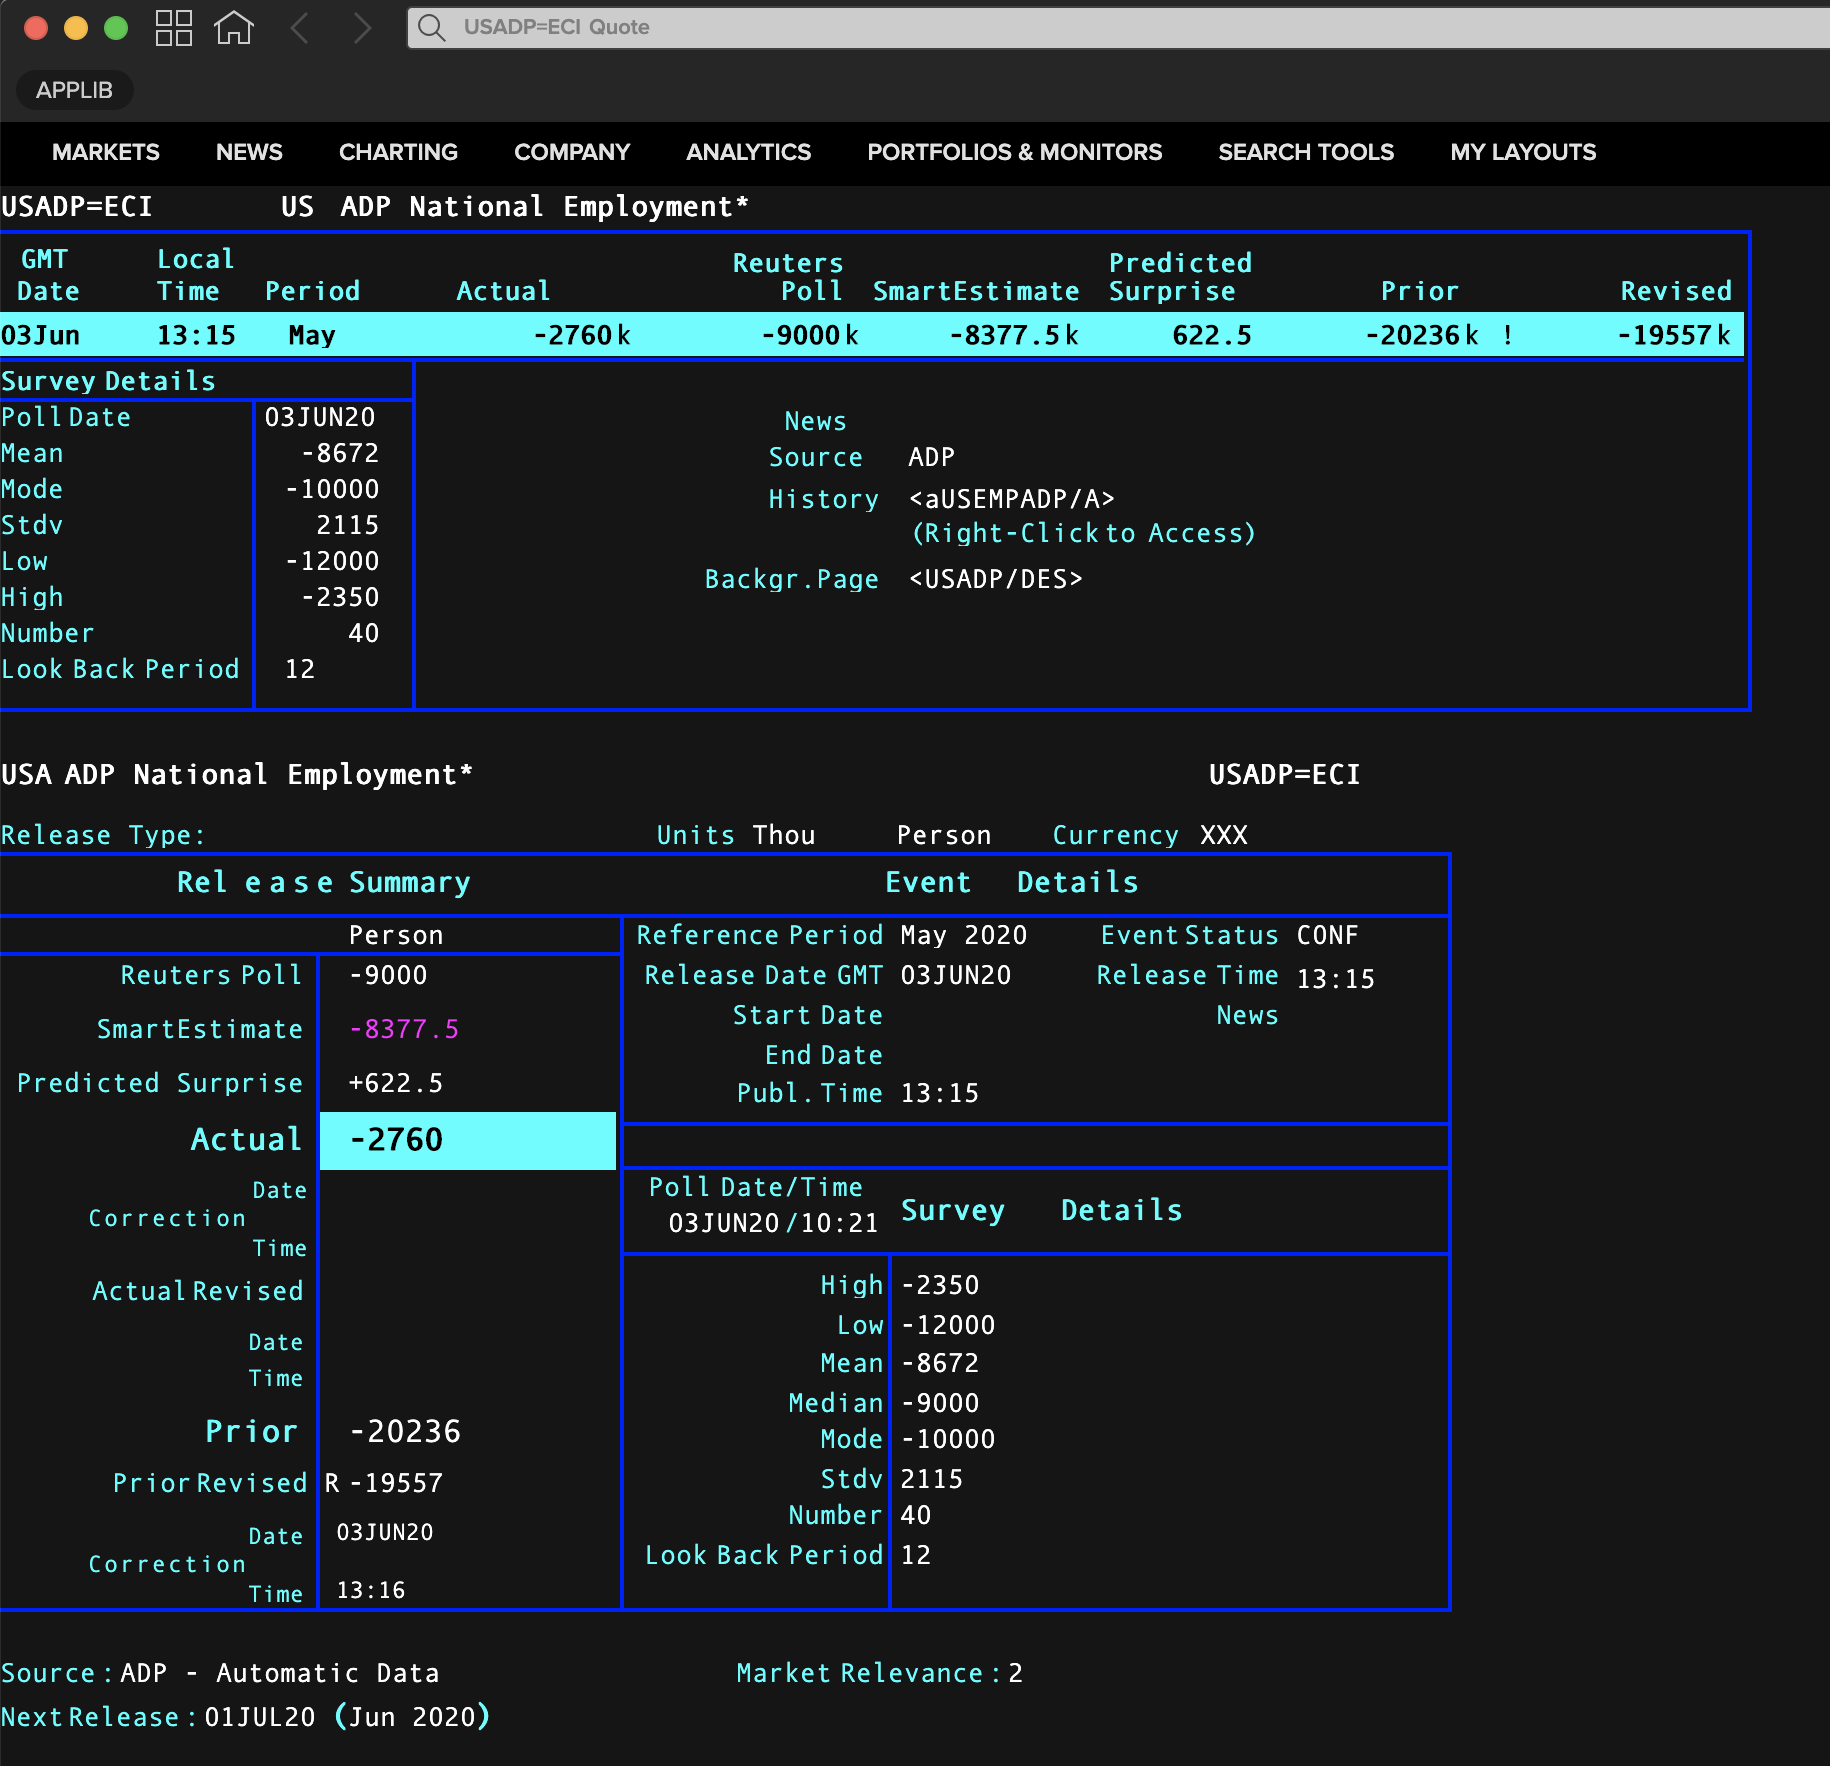



In [2]:
data, err = ek.get_data(['0#ECONALLUS'],
['DSPLY_NMLL','RELEVANCE','ACT_REL_ST','ECI_ACT_DT','ACT_VAL_NS','UNIT_PREFX','FCAST_PRD','RPT_UNITS','ECON_ACT','ECON_PRIOR','RTR_POLL',
 'FCAST_SEST','FCAST_ACRY','NDOR_1'])
data = data[data['ECI_ACT_DT']>='2020-06-09'] #from today forward (note DateTimes are in GMT!)
data.sort_values(['ECI_ACT_DT','ACT_VAL_NS'],ascending=True,inplace=True) # Sort on release date & Time

data

,Instrument,DSPLY_NMLL,RELEVANCE,ACT_REL_ST,ECI_ACT_DT,ACT_VAL_NS,UNIT_PREFX,FCAST_PRD,RPT_UNITS,ECON_ACT,ECON_PRIOR,RTR_POLL,FCAST_SEST,FCAST_ACRY,NDOR_1
58,USFFP1=ECI,FFR Projection-1st Yr*,0.0,CONF,2020-06-10,18:00:00,,Q2 2020,Percent,0.100,1.600,NaN,NaN,NaN,2020-09-16
59,USFFP2=ECI,FFR Projection-2nd Yr*,0.0,CONF,2020-06-10,18:00:00,,Q2 2020,Percent,0.100,1.900,NaN,NaN,NaN,2020-09-16
61,USFFPL=ECI,FFR Projection-Longer*,0.0,CONF,2020-06-10,18:00:00,,Q2 2020,Percent,2.500,2.500,NaN,NaN,NaN,2020-09-16
62,USFFPQ=ECI,FFR Projection-Current*,0.0,CONF,2020-06-10,18:00:00,,Q2 2020,Percent,0.100,1.600,NaN,NaN,NaN,2020-09-16
63,USFOMC=ECI,Fed Funds Tgt Rate,3.0,CONF,2020-06-10,18:00:00,None,11 Jun,Percent,0.125,0.125,NaN,NaN,NaN,2020-07-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,USDGNT=ECI,Durables Ex-Transpt R MM,1.0,CONF,2020-08-04,14:00:00,,Jun 2020,Percent,NaN,NaN,NaN,NaN,NaN,2020-09-02
44,USDGR=ECI,"Durable Goods, R MM",1.0,CONF,2020-08-04,14:00:00,,Jun 2020,Percent,NaN,NaN,NaN,NaN,NaN,2020-09-02
64,USFORD=ECI,Factory Orders MM,3.0,CONF,2020-08-04,14:00:00,,Jun 2020,Percent,NaN,8.000,NaN,NaN,NaN,2020-09-02
66,USFXTR=ECI,Factory Ex-Transp MM,1.0,CONF,2020-08-04,14:00:00,,Jun 2020,Percent,NaN,2.600,NaN,NaN,NaN,2020-09-02


Real-time Indicator retrieval from the timeseries service is different from other RIC instruments in that we **DO NOT** request field types (eg Open High Low Close) and we set the interval to monthly. Lets see how it works using the ADP payroll number for the last 10 years of monthly releases. Note that I have also added 3 other RICs that seem to be derived from the same underlying RIC. These are the poll values associated with the monthly release (hence the lowercase p preceding the RIC) and then we have Median, Low & High Values (the =M,=L,=H respectively succeding the RIC)

In [3]:
df = ek.get_timeseries(['USADP=ECI','pUSADP=M','pUSADP=L','pUSADP=H'],
                       start_date='2010-03-01',end_date='2020-04-26',interval='monthly',)
df

VALUE,USADP=ECI,pUSADP=M,pUSADP=L,pUSADP=H
Date,,,,
2010-03-31,-11000.0,40000.0,-20000.0,180000.0
2010-04-30,132000.0,30000.0,0.0,80000.0
2010-05-31,211000.0,60000.0,32000.0,180000.0
2010-06-30,175000.0,60000.0,23000.0,100000.0
2010-07-31,116000.0,40000.0,13000.0,85000.0
...,...,...,...,...
2019-11-30,161000.0,140000.0,120000.0,188000.0
2019-12-31,167000.0,160000.0,77000.0,225000.0
2020-01-31,205000.0,156000.0,140000.0,215000.0


<a id='NRTE'></a>
### Non Real-time Economic Indicators

As mentioned earlier Eikon carries just shy of 400,000 non-realtime economic indicators covering a whole host of indicator types listed above. Once you have found the list that you wish to download - just copy and paste those into a historical timeseries call this time for Monthly German New Car Production and registration: 

In [4]:
df = ek.get_timeseries(['aDEPROCARP','aDEACECARP','aDECOMPLIDX/A'],
                       start_date='2010-03-01',end_date='2020-04-26',interval='monthly')
df

VALUE,aDEPROCARP,aDEACECARP,aDECOMPLIDX/A
Date,,,
2010-03-31,560055.0,294374.0,100.99630
2010-04-30,464591.0,259414.0,101.25930
2010-05-31,470130.0,249708.0,101.48670
2010-06-30,528820.0,289259.0,101.69970
2010-07-31,392553.0,237428.0,101.92020
...,...,...,...
2019-11-30,423400.0,299127.0,99.14215
2019-12-31,276400.0,283380.0,99.24992
2020-01-31,341600.0,246300.0,99.35624


<a id='PIAT'></a>
### Putting it all together - a basic machine learning sample

So given our new found economic indicator discovery workflow - lets try to put this data to work to see if we can come up with something of interest. In this case lets try to download all available auto industry indicators for all countries in the world and see if this can help explain movement in some global automakers. In order to do this we will be using an XGBoost model which a gradient boosted decision-tree class of algorithm. 

From the Economic Search app I have identified a list of global economic indicators from the automobile industry and have downloaded these rics to an excel file - which I can now read into pandas and also use in my get_timeseries call.

In [5]:
riclist = pd.read_excel('/Users/jasonram/Downloads/autoric1.xlsx') #or the location of your saved Excel file

In [6]:
allRics = riclist['RIClist'].astype(str).values.tolist()

In [7]:
allRics

['IDMBKY=ECI',
 'IDCARY=ECI',
 'USCARS=ECI',
 'ESCARM=ECI',
 'ESCARY=ECI',
 'ITCARM=ECI',
 'DECARM=ECI',
 'DECARY=ECI',
 'GBCARY=ECI',
 'ZAVEHY=ECI',
 'GBCARM=ECI',
 'BECARM=ECI',
 'BECARY=ECI',
 'ZAVEHA=ECI',
 'FRCARY=ECI',
 'FRCARM=ECI',
 'ITCARY=ECI',
 'GBPCRG=ECI',
 'BRASLM=ECI',
 'NLCARM=ECI',
 'LUCARM=ECI',
 'LUCARY=ECI',
 'NLCARY=ECI',
 'SKCARM=ECI',
 'SKCARY=ECI',
 'CZCARY=ECI',
 'PLCARM=ECI',
 'PLCARY=ECI',
 'ROCARM=ECI',
 'CZCARM=ECI',
 'ROCARY=ECI',
 'HUCARM=ECI',
 'HUCARY=ECI',
 'aUSVHLS',
 'aINDVEHCAR',
 'aHKMVEHRLIC',
 'aHKMVEHRREG',
 'aXFNCAR',
 'aUSVDTMOM',
 'aXZNCAR',
 'aUSNCAR/A',
 'aUSPTRDEP',
 'aRUTOSLCLCV',
 'aFRNCAR',
 'aUSPTRAMF',
 'aMMTRWATPP',
 'aEGSUEZTR',
 'aARNCAR',
 'aTRMVEHREG',
 'aESNCAR',
 'aSENCAR',
 'aUSTLVS.1D',
 'aUSTRANS/A',
 'aUSACRFRM',
 'aUSTRANSF/A',
 'aEGSCTRECA',
 'aTHNCAR',
 'aBRDVSREG',
 'aNLNVECARCA',
 'aAUNCAR',
 'aMYCARP',
 'aITACECARP',
 'aBRDVEHCAR',
 'aKRNCAR',
 'aTRNCAR',
 'aBENCAR',
 'aTWNCAR',
 'aATNCAR',
 'aUSDVEHCAR/A',
 'aUSTKLSA

In [8]:
len(allRics)

260

In [9]:
start='2010-03-01'
end='2020-04-26'
ts = pd.DataFrame()
df = pd.DataFrame()

for r in allRics:
    try:
        ts = ek.get_timeseries(r,start_date=start,end_date=end,interval='monthly')
        ts.rename(columns = {'VALUE': r}, inplace = True)
        if len(ts):
            df = pd.concat([df, ts], axis=1)
        else:
            df = ts
    except:
        pass
    
df

,IDMBKY=ECI,IDCARY=ECI,USCARS=ECI,ESCARM=ECI,ESCARY=ECI,ITCARM=ECI,DECARM=ECI,DECARY=ECI,GBCARY=ECI,ZAVEHY=ECI,...,aLUNHTREG,aLTNHTREG,aSGMANPOP,aJPPNISS,aCATRKSBSP,aUSAUIMMXP,aGBACECARP,aLUNCAR,aISNVEHREG/A,aROACECARP
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,39.6,92.1,5630000.0,36.7,63.1,28.5,51.1,-26.6,26.6,24.7,...,77.0,43.0,933225.0,99903.0,77800.0,93816.0,397383.0,3231.0,224.010250,9923.0
2010-04-30,70.0,88.5,5480000.0,-24.9,39.3,-37.9,-11.9,-31.7,11.5,38.8,...,54.0,86.0,935024.0,86180.0,81675.0,75715.0,148793.0,3307.0,126.812220,10376.0
2010-05-31,39.9,69.0,5720000.0,9.9,44.6,2.4,-3.7,-35.1,13.5,40.5,...,42.0,85.0,936311.0,79430.0,82402.0,73661.0,153095.0,2947.0,238.749611,10758.0
2010-06-30,34.7,77.9,5640000.0,18.1,25.6,4.3,15.8,-32.3,10.8,19.7,...,61.0,74.0,937860.0,100471.0,84009.0,79809.0,195226.0,2792.0,525.231951,13892.0
2010-07-31,28.4,72.0,5740000.0,-32.4,-24.1,-10.4,-17.9,-30.2,-13.2,23.4,...,76.0,139.0,938922.0,96956.0,83218.0,76143.0,136446.0,2312.0,472.853610,8336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,-8.3,-9.4,4380000.0,-0.9,2.3,-4.0,5.1,9.7,-1.3,-5.8,...,NaN,NaN,972224.0,65092.0,114988.0,75933.0,156621.0,1511.0,1604.147896,13091.0
2019-12-31,-6.8,-0.2,4490000.0,13.6,6.6,-7.0,-5.3,19.5,3.4,4.2,...,NaN,NaN,973101.0,61201.0,91368.0,96974.0,148997.0,1248.0,1386.820577,13773.0
2020-01-31,-18.7,-2.1,4370000.0,-18.3,-7.6,11.0,-13.1,-7.3,-7.3,-8.1,...,NaN,NaN,973534.0,65812.0,90008.0,56975.0,149279.0,1640.0,NaN,12489.0


In [10]:
df.describe()

,IDMBKY=ECI,IDCARY=ECI,USCARS=ECI,ESCARM=ECI,ESCARY=ECI,ITCARM=ECI,DECARM=ECI,DECARY=ECI,GBCARY=ECI,ZAVEHY=ECI,...,aLUNHTREG,aLTNHTREG,aSGMANPOP,aJPPNISS,aCATRKSBSP,aUSAUIMMXP,aGBACECARP,aLUNCAR,aISNVEHREG/A,aROACECARP
count,121.000000,121.000000,1.210000e+02,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,...,70.000000,70.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,118.000000,121.000000
mean,1.989256,8.971901,6.429669e+06,1.719835,3.452893,4.186777,1.361157,0.227273,1.167769,2.982645,...,77.742857,219.414286,960183.859504,81079.975207,99080.884298,100680.198347,194813.760331,1760.975207,1297.845786,8219.776860
std,18.529849,23.429430,1.102691e+06,20.667017,20.016614,35.981592,16.818400,11.737554,10.016605,11.891570,...,20.483776,92.862606,9862.880360,16003.024972,23965.353378,17986.371146,112509.688567,451.704466,723.767425,3842.194756
min,-36.800000,-39.100000,2.880000e+06,-60.200000,-69.300000,-82.600000,-36.700000,-37.700000,-44.400000,-29.700000,...,36.000000,43.000000,933225.000000,44193.000000,54137.000000,56975.000000,55305.000000,933.000000,126.812220,2771.000000
25%,-10.300000,-5.300000,5.660000e+06,-10.600000,-8.100000,-12.700000,-9.600000,-4.700000,-4.100000,-4.500000,...,62.500000,148.750000,955156.000000,70698.000000,81675.000000,89349.000000,137746.000000,1418.000000,734.942203,5599.000000
50%,1.800000,4.700000,6.550000e+06,5.400000,5.200000,-2.300000,-2.300000,2.600000,2.400000,0.300000,...,76.500000,215.500000,959314.000000,79267.000000,93633.000000,100294.000000,163357.000000,1756.000000,1128.116730,7362.000000
75%,10.500000,17.300000,7.480000e+06,15.000000,15.200000,13.500000,7.900000,7.400000,8.000000,8.200000,...,93.000000,265.500000,969728.000000,93607.000000,116544.000000,115554.000000,195226.000000,2038.000000,1969.269372,9811.000000
max,76.400000,92.100000,8.170000e+06,36.700000,63.100000,124.100000,51.200000,24.700000,26.600000,40.500000,...,127.000000,574.000000,974495.000000,120217.000000,151810.000000,135565.000000,562337.000000,3307.000000,2695.983608,28546.000000


Importantly, we now want to create some lags for our data to see if there is any lagged effect for our data. 

In [11]:
dfs = df.copy()

In [12]:
lags = 6
for r in dfs.columns.values:
    for lag in range(1, lags + 1):
        dfs[r +'_lag_{}'.format(lag)] = dfs[r].shift(lag)

dfs

,IDMBKY=ECI,IDCARY=ECI,USCARS=ECI,ESCARM=ECI,ESCARY=ECI,ITCARM=ECI,DECARM=ECI,DECARY=ECI,GBCARY=ECI,ZAVEHY=ECI,...,aISNVEHREG/A_lag_3,aISNVEHREG/A_lag_4,aISNVEHREG/A_lag_5,aISNVEHREG/A_lag_6,aROACECARP_lag_1,aROACECARP_lag_2,aROACECARP_lag_3,aROACECARP_lag_4,aROACECARP_lag_5,aROACECARP_lag_6
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-31,39.6,92.1,5630000.0,36.7,63.1,28.5,51.1,-26.6,26.6,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-30,70.0,88.5,5480000.0,-24.9,39.3,-37.9,-11.9,-31.7,11.5,38.8,...,NaN,NaN,NaN,NaN,9923.0,NaN,NaN,NaN,NaN,NaN
2010-05-31,39.9,69.0,5720000.0,9.9,44.6,2.4,-3.7,-35.1,13.5,40.5,...,NaN,NaN,NaN,NaN,10376.0,9923.0,NaN,NaN,NaN,NaN
2010-06-30,34.7,77.9,5640000.0,18.1,25.6,4.3,15.8,-32.3,10.8,19.7,...,224.010250,NaN,NaN,NaN,10758.0,10376.0,9923.0,NaN,NaN,NaN
2010-07-31,28.4,72.0,5740000.0,-32.4,-24.1,-10.4,-17.9,-30.2,-13.2,23.4,...,126.812220,224.010250,NaN,NaN,13892.0,10758.0,10376.0,9923.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,-8.3,-9.4,4380000.0,-0.9,2.3,-4.0,5.1,9.7,-1.3,-5.8,...,1426.873182,1214.162249,1058.299246,1219.266184,10649.0,6046.0,23177.0,23206.0,14082.0,13011.0
2019-12-31,-6.8,-0.2,4490000.0,13.6,6.6,-7.0,-5.3,19.5,3.4,4.2,...,1444.425137,1426.873182,1214.162249,1058.299246,13091.0,10649.0,6046.0,23177.0,23206.0,14082.0
2020-01-31,-18.7,-2.1,4370000.0,-18.3,-7.6,11.0,-13.1,-7.3,-7.3,-8.1,...,1497.699721,1444.425137,1426.873182,1214.162249,13773.0,13091.0,10649.0,6046.0,23177.0,23206.0


<a id='LABELS'></a>
### Adding Target Variables or Labels

So we now have our feature matrix with all our raw and lagged data. Now lets add some target variables or labels. We will be adding two types of label that I think encompass many of the use cases - firstly a timeseries of monthly closing prices as a label - and secondly a company fundamental monthly timeseries - in our case the IBES consensus revenue estimate for FY1. You will see its very straightforward to download and then concatenate these types of label data to your feature matrix. Here we use BMW as an example as it is a global automaker.

In [13]:
df1 = ek.get_timeseries(['BMWG.DE'],['CLOSE'],
                       start_date='2010-03-01',end_date='2020-04-26',interval='monthly')
df1

BMWG.DE,CLOSE
Date,
2010-03-31,34.180
2010-04-30,37.130
2010-05-31,37.965
2010-06-30,40.065
2010-07-31,41.310
...,...
2019-11-30,73.300
2019-12-31,73.140
2020-01-31,64.340


In [14]:
df2, err = ek.get_data('BMWG.DE',['TR.RevenueMean(SDate=-3,EDate=-123,Period=FY1,Frq=CM).calcdate','TR.RevenueMean(SDate=-3,EDate=-123,Period=FY1,Frq=M)'])
df2['Calc Date'] = pd.to_datetime(df2['Calc Date'].str[:10])
df2.set_index('Calc Date', inplace=True)
df2.sort_index(ascending=True, inplace=True)
df2

,Instrument,Revenue - Mean
Calc Date,,
2010-03-31,BMWG.DE,52395861610
2010-04-30,BMWG.DE,52566096720
2010-05-31,BMWG.DE,53593869130
2010-06-30,BMWG.DE,53757373350
2010-07-31,BMWG.DE,55526963730
...,...,...
2019-11-30,BMWG.DE,100616380300
2019-12-31,BMWG.DE,100905726390
2020-01-31,BMWG.DE,101207227710


In [15]:
dfs = pd.concat([dfs, df1], axis=1)
dfs = pd.concat([dfs, df2['Revenue - Mean']], axis=1)
dfs

,IDMBKY=ECI,IDCARY=ECI,USCARS=ECI,ESCARM=ECI,ESCARY=ECI,ITCARM=ECI,DECARM=ECI,DECARY=ECI,GBCARY=ECI,ZAVEHY=ECI,...,aISNVEHREG/A_lag_5,aISNVEHREG/A_lag_6,aROACECARP_lag_1,aROACECARP_lag_2,aROACECARP_lag_3,aROACECARP_lag_4,aROACECARP_lag_5,aROACECARP_lag_6,CLOSE,Revenue - Mean
2010-03-31,39.6,92.1,5630000.0,36.7,63.1,28.5,51.1,-26.6,26.6,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.180,52395861610
2010-04-30,70.0,88.5,5480000.0,-24.9,39.3,-37.9,-11.9,-31.7,11.5,38.8,...,NaN,NaN,9923.0,NaN,NaN,NaN,NaN,NaN,37.130,52566096720
2010-05-31,39.9,69.0,5720000.0,9.9,44.6,2.4,-3.7,-35.1,13.5,40.5,...,NaN,NaN,10376.0,9923.0,NaN,NaN,NaN,NaN,37.965,53593869130
2010-06-30,34.7,77.9,5640000.0,18.1,25.6,4.3,15.8,-32.3,10.8,19.7,...,NaN,NaN,10758.0,10376.0,9923.0,NaN,NaN,NaN,40.065,53757373350
2010-07-31,28.4,72.0,5740000.0,-32.4,-24.1,-10.4,-17.9,-30.2,-13.2,23.4,...,NaN,NaN,13892.0,10758.0,10376.0,9923.0,NaN,NaN,41.310,55526963730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,-8.3,-9.4,4380000.0,-0.9,2.3,-4.0,5.1,9.7,-1.3,-5.8,...,1058.299246,1219.266184,10649.0,6046.0,23177.0,23206.0,14082.0,13011.0,73.300,100616380300
2019-12-31,-6.8,-0.2,4490000.0,13.6,6.6,-7.0,-5.3,19.5,3.4,4.2,...,1214.162249,1058.299246,13091.0,10649.0,6046.0,23177.0,23206.0,14082.0,73.140,100905726390
2020-01-31,-18.7,-2.1,4370000.0,-18.3,-7.6,11.0,-13.1,-7.3,-7.3,-8.1,...,1426.873182,1214.162249,13773.0,13091.0,10649.0,6046.0,23177.0,23206.0,64.340,101207227710
2020-02-29,2.6,-2.6,4250000.0,9.5,-6.0,4.7,-2.6,-10.8,-2.9,-0.7,...,1444.425137,1426.873182,12489.0,13773.0,13091.0,10649.0,6046.0,23177.0,58.930,101460894380


Next we need to standardise our data before we feed it to the XGBoost routine and that means both the feature matrix and the labels. In our case we will use a simple to calculate z-score. As you will see this is applying to all our current feature and label concatenated frame.

In [16]:
b = list(dfs.columns[0:].values)
for col in b:
    col_zscore = col + '_zscore'
    dfs[col_zscore] = (dfs[col] - dfs[col].mean())/dfs[col].std(ddof=0)
dfs

,IDMBKY=ECI,IDCARY=ECI,USCARS=ECI,ESCARM=ECI,ESCARY=ECI,ITCARM=ECI,DECARM=ECI,DECARY=ECI,GBCARY=ECI,ZAVEHY=ECI,...,aISNVEHREG/A_lag_5_zscore,aISNVEHREG/A_lag_6_zscore,aROACECARP_lag_1_zscore,aROACECARP_lag_2_zscore,aROACECARP_lag_3_zscore,aROACECARP_lag_4_zscore,aROACECARP_lag_5_zscore,aROACECARP_lag_6_zscore,CLOSE_zscore,Revenue - Mean_zscore
2010-03-31,39.6,92.1,5630000.0,36.7,63.1,28.5,51.1,-26.6,26.6,24.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.546434,-2.192459
2010-04-30,70.0,88.5,5480000.0,-24.9,39.3,-37.9,-11.9,-31.7,11.5,38.8,...,NaN,NaN,0.440206,NaN,NaN,NaN,NaN,NaN,-2.359657,-2.180444
2010-05-31,39.9,69.0,5720000.0,9.9,44.6,2.4,-3.7,-35.1,13.5,40.5,...,NaN,NaN,0.558189,0.439728,NaN,NaN,NaN,NaN,-2.306790,-2.107907
2010-06-30,34.7,77.9,5640000.0,18.1,25.6,4.3,15.8,-32.3,10.8,19.7,...,NaN,NaN,0.657681,0.557231,0.449537,NaN,NaN,NaN,-2.173830,-2.096368
2010-07-31,28.4,72.0,5740000.0,-32.4,-24.1,-10.4,-17.9,-30.2,-13.2,23.4,...,NaN,NaN,1.473930,0.656318,0.567156,0.464146,NaN,NaN,-2.095004,-1.971475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-30,-8.3,-9.4,4380000.0,-0.9,2.3,-4.0,5.1,9.7,-1.3,-5.8,...,-0.325140,-0.100668,0.629292,-0.565924,3.890867,3.929603,1.564926,1.287398,-0.069580,1.210808
2019-12-31,-6.8,-0.2,4490000.0,13.6,6.6,-7.0,-5.3,19.5,3.4,4.2,...,-0.110532,-0.321422,1.265310,0.628044,-0.557105,3.922037,3.952333,1.566968,-0.079711,1.231230
2020-01-31,-18.7,-2.1,4370000.0,-18.3,-7.6,11.0,-13.1,-7.3,-7.3,-8.1,...,0.182350,-0.107668,1.442937,1.261473,0.638039,-0.547340,3.944745,3.948669,-0.636876,1.252509
2020-02-29,2.6,-2.6,4250000.0,9.5,-6.0,4.7,-2.6,-10.8,-2.9,-0.7,...,0.206517,0.184048,1.108520,1.438376,1.272091,0.653555,-0.537793,3.941099,-0.979406,1.270412


Next we need to make sure we identify the right features to pass to the XGBoost model - we only wish to pass the zscore features.

In [18]:
mycols = dfs.columns
mycols[1822:-2]

Index(['IDMBKY=ECI_zscore', 'IDCARY=ECI_zscore', 'USCARS=ECI_zscore',
       'ESCARM=ECI_zscore', 'ESCARY=ECI_zscore', 'ITCARM=ECI_zscore',
       'DECARM=ECI_zscore', 'DECARY=ECI_zscore', 'GBCARY=ECI_zscore',
       'ZAVEHY=ECI_zscore',
       ...
       'aISNVEHREG/A_lag_3_zscore', 'aISNVEHREG/A_lag_4_zscore',
       'aISNVEHREG/A_lag_5_zscore', 'aISNVEHREG/A_lag_6_zscore',
       'aROACECARP_lag_1_zscore', 'aROACECARP_lag_2_zscore',
       'aROACECARP_lag_3_zscore', 'aROACECARP_lag_4_zscore',
       'aROACECARP_lag_5_zscore', 'aROACECARP_lag_6_zscore'],
      dtype='object', length=1820)

We are now getting into the machine learning section. So we need to split our data in train and test sets.

In [19]:
split_date = '01-01-2015'
pri_train = dfs.loc[dfs.index <= split_date].copy()
pri_test = dfs.loc[dfs.index > split_date].copy()

We also need to a function to create our feature and label sets and then we go ahead and create our X_train (training features set), y_train (training label set), X_test (test features set), y_test (test label set).

In [20]:
def create_features(df, label=None):
    collist = df.columns.tolist()
    relcols = collist[1822:-2]      
    X = df[relcols]
    if label:
        y = df[label].to_frame()
        return X, y
    return X

In [21]:
X_train, y_train = create_features(pri_train, label='CLOSE_zscore')
X_test, y_test = create_features(pri_test, label='CLOSE_zscore')

Finally I usually just do a date check - to see all dates are properly aligned.

In [22]:
print(X_train.index.min(), y_train.index.min(), X_train.index.max(),y_train.index.max())

2010-03-31 00:00:00 2010-03-31 00:00:00 2014-12-31 00:00:00 2014-12-31 00:00:00


In [23]:
print(X_test.index.min(), y_test.index.min(), X_test.index.max(),y_test.index.max())

2015-01-31 00:00:00 2015-01-31 00:00:00 2020-03-31 00:00:00 2020-03-31 00:00:00


<a id='XGB'></a>
### Define and fit XGBoost model

Finally we start defining our XGBoost model (in our case we use a simple vanilla setup) - then we pass our training set and test set to fit our model. Once we have done that we can have visualise our feature importance as a plot. 

In [24]:
reg = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

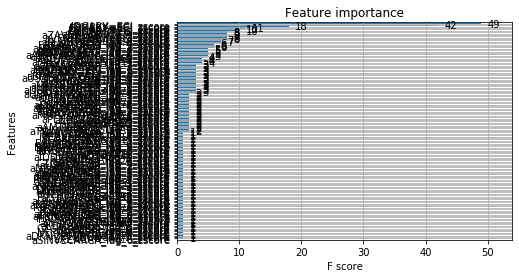

In [27]:
_ = plot_importance(reg, height=0.9)

Finally - we can use our model to create an ML_Prediction for our label set given our X_test set and then compare that to actual observations of the label set. 

In [28]:
pri_test1 = pri_test.copy()
pri_test1['ML_Prediction'] = reg.predict(X_test)
pri_all = pd.concat([pri_test1, pri_train], sort=False)

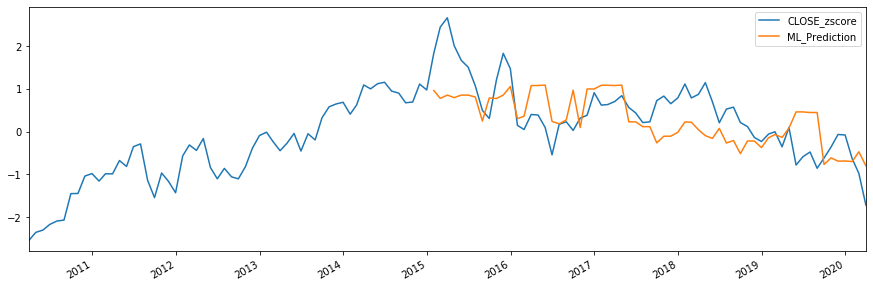

In [29]:
_ = pri_all[['CLOSE_zscore','ML_Prediction']].plot(figsize=(15, 5))

<a id='CONCL'></a>
### Conclusion

In this article we have discussed the economic content available in Eikon. We talked about real-time and non-realtime economic indicators and how you can discover and use this data in your workflows using our search discovery tools. We also showed an example of real-time indicator monitoring - similar to the **Economic Monitor (EM)** app in Eikon.

Then we moved on to an example which puts a lot of this into practice using a simple machine learning example. We found a group of automobile industry data using our search discovery tools and then saved those down as a spreadsheet. The we used those RICs to download the timeseries for these economic indicators. We created some new (derived) features by creating 6 months worth of lagged data. Once we had completed our raw feature matrix - we showed how to get two types of typical label data - a price series (in our case monthly BMW closing prices) and also an example of some fundamental data for BMW (in our case Monthly IBES consenus Revenue estimates). We then standardised our data using z-scores, a very common method followed by splitting our data into training and test sets and created our feature and label sets for both. We then defined a simple XGBoost model and handed our data to it to fit. Once that was complete we then created a model prediction for our label set (in our case BMW monthly closing prices) and then visualised this is a chart. 

The model was able to generate some kind of prediction - which doesn't seem that compelling - but is not entirely without merit. The model is broadly predicting lower prices for the stock based on our economic indicator factors and this has broadly been evidenced in the test set. 

Whilst a simple example, I hope this article has demystified this type of workflow and provided you with a practical codebase to explore further. 

<a id='Resources'></a>
**Further Resources for Eikon Data API**

* [Overview](https://developers.refinitiv.com/eikon-data-apis) 
* [Quick Start ](https://developers.refinitiv.com/eikon-data-apis/quick-start)
* [Documentation](https://developers.refinitiv.com/eikon-data-apis/docs)
* [Downloads](https://developers.refinitiv.com/eikon-data-apis/downloads)
* [Tutorials](https://developers.refinitiv.com/eikon-data-apis/learning)
* [Q&A Forums](https://developers.refinitiv.com/eikon-data-apis/qa)

For Content Navigation in Eikon - please use the Data Item Browser Application: Type 'DIB' into Eikon Search Bar.